In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List, Tuple
from math import floor
import random
from itertools import chain
from thesispy.definitions import ROOT_DIR, IMG_DIR

cmap = plt.get_cmap("Paired").colors

# plt.style.use(["science", "high-vis", ROOT_DIR / "resources/plt_custom.txt"])
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

class Point:
  def __init__(self, x: float = 0.0, y: float = 0.0):
    self.x = x
    self.y = y

  def __mul__(self, other):
    return Point(
        self.x * float(other),
        self.y * float(other)
    )

  def __add__(self, other):
    return Point(
        self.x + other.x,
        self.y + other.y
    )
  
  def __str__(self):
    return f"({self.x}, {self.y})"

  def reset(self):
    self.x = 0.0
    self.y = 0.0
  
  __rmul__ = __mul__
  __repr__ = __str__

def cubic_bspline_0(t: float):
  return (-t**3 + 3*t**2 - 3*t + 1)/6

def cubic_bspline_1(t: float):
  return (3*t**3 - 6*t**2 + 4)/6

def cubic_bspline_2(t: float):
  return (-3*t**3 + 3*t**2 + 3*t + 1)/6

def cubic_bspline_3(t: float):
  return t**3/6

cubic_bsplines = [cubic_bspline_0, cubic_bspline_1, cubic_bspline_2, cubic_bspline_3]

def cubic_bspline_patch(x: float, y: float, c: List[List[Point]], verbose=False):
  res = Point()
  i = floor(x)
  j = floor(y)

  if (i == 0 or i + 3 > len(c)) or (j == 0 or j + 3 > len(c)):
    if verbose:
      print(f"Patch is not defined for ({x},{y}).")
    return None

  for m in range(4):
    for n in range(4):
      if verbose:
        print(f"bspline_{m}({x-i}) * bspline_{n}({y-j}) * {c[i+m-1][j+n-1]}")
      res += cubic_bsplines[m](x - i) * cubic_bsplines[n](y-j) * c[i+m-1][j+n-1]
  
  return res

def cubic_affected_pixels(s: List[Tuple], c: List[List[Point]]):
  flatten_c = list(chain.from_iterable(c))
  flatten_s = [c[m][n] for m,n in s]
  max_limit = Point(max([p.x for p in flatten_c]) - 1, max([p.y for p in flatten_c]) - 1)
  min_limit = Point(min([p.x for p in flatten_c]) + 1, min([p.y for p in flatten_c]) + 1)
  
  res = []
  for m,n in s:
    p1 = Point(max(min_limit.x, c[m][n].x-2), max(min_limit.y, c[m][n].y-2))
    p2 = Point(min(max_limit.x, c[m][n].x+2), min(max_limit.y, c[m][n].y+2))
    res.append((p1,p2))

  return res


def generate_grid(n: int, r=False):
  res = []
  for i in range(n):
    res.append([Point(i+random.uniform(0, 1), j+random.uniform(0, 1)) if r else Point(i, j) for j in range(n)])
  return np.array(res)

def plot_patch(c, ax=None, skip_patches=False):
  if ax is None:
    _, ax = plt.subplots(figsize=(6,6))
  cpoints_x = [p.x for p in c.flatten()]
  cpoints_y = [p.y for p in c.flatten()]
  ax.scatter(cpoints_x, cpoints_y, c='black', marker='+', zorder=100)

  if not skip_patches:
    axis_vals = np.linspace(0, c.shape[0], 100)

    for x in range(2, c.shape[0]-1):
      p1 = []
      p2 = []
      for y in axis_vals:
        p1.append(cubic_bspline_patch(x, y, c))
        p2.append(cubic_bspline_patch(y, x, c))

      p1 = np.array(p1)
      p2 = np.array(p2)
      p1_x = [p.x for p in p1.flatten()[p1 != np.array(None)]]
      p1_y = [p.y for p in p1.flatten()[p1 != np.array(None)]]
      p2_x = [p.x for p in p2.flatten()[p2 != np.array(None)]]
      p2_y = [p.y for p in p2.flatten()[p2 != np.array(None)]]

      ax.plot(p1_x, p1_y, c=cmap[5], linestyle='-')
      ax.plot(p2_x, p2_y, c=cmap[5], linestyle='-')

def generate_dvf(c):
  dvf = np.zeros(list(c.shape) + [2])
  for p in np.ndindex(c.shape):
    mappedPoint = cubic_bspline_patch(p[0], p[1], c)
    if mappedPoint:
      direction = c[p] + -1 * mappedPoint
      dvf[p][0] = direction.x
      dvf[p][1] = direction.y
  return dvf


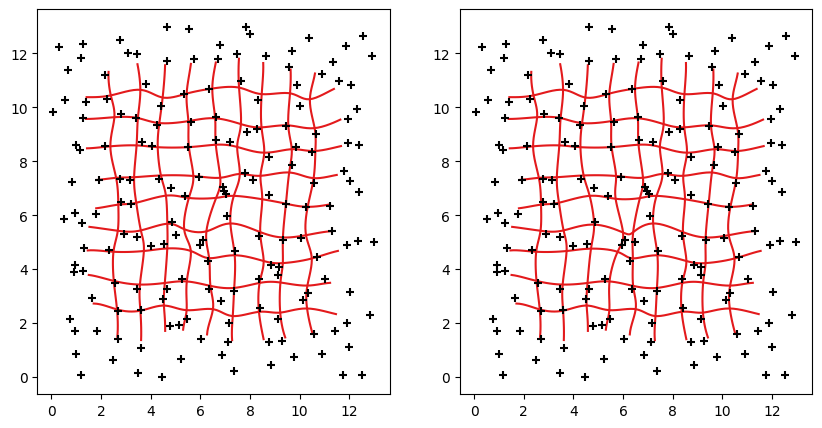

In [2]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

grid_size = 13
c = generate_grid(grid_size, True)

plot_patch(c, ax=axes[0])

c[5][5] = Point(6.5, 5)

plot_patch(c, ax=axes[1])

# plt.savefig(IMG_DIR / "bspline_patches.pgf", dpi=300, bbox_inches='tight')

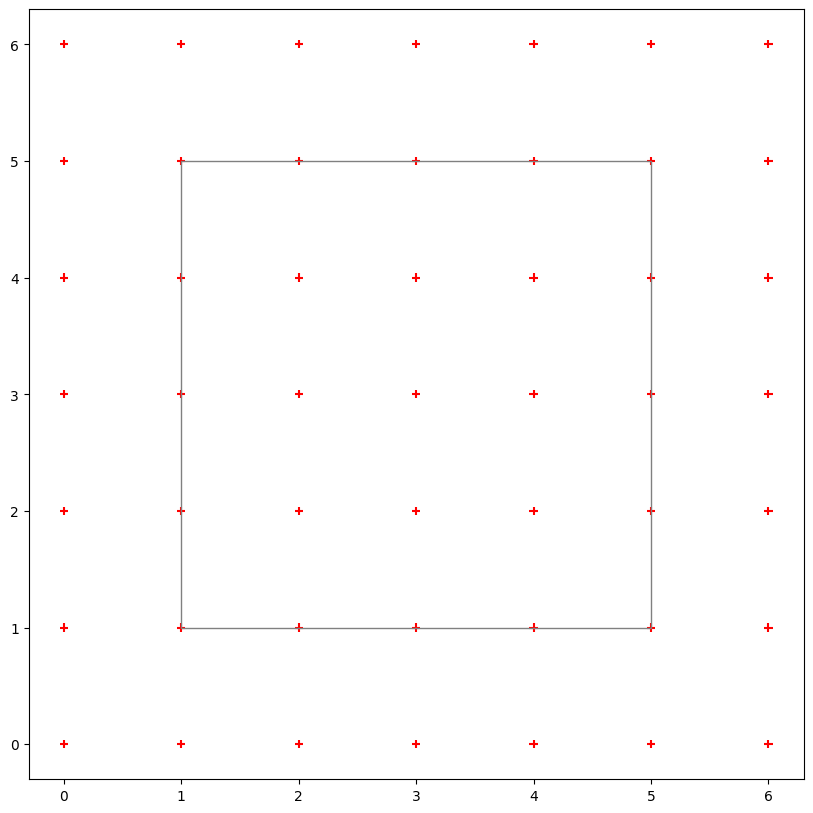

In [3]:
n = 7
dist = n-3
c = generate_grid(n)
colors = [['r' for _ in x] for x in c]
selection = []
for m,n in selection:
  colors[m][n] = 'b'
rects = cubic_affected_pixels(selection, c)
colors = list(chain.from_iterable(colors))

fig, ax = plt.subplots(figsize=(10,10))
cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]
ax.scatter(cpoints_x, cpoints_y, c=colors, marker='+')

outer_rect = patches.Rectangle((1, 1), dist, dist, linewidth=1, edgecolor='gray', facecolor='none')
ax.add_patch(outer_rect)

for p1, p2 in rects:
  rect = patches.Rectangle((p1.x, p1.y), p2.x - p1.x, p2.y - p1.y, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(rect)

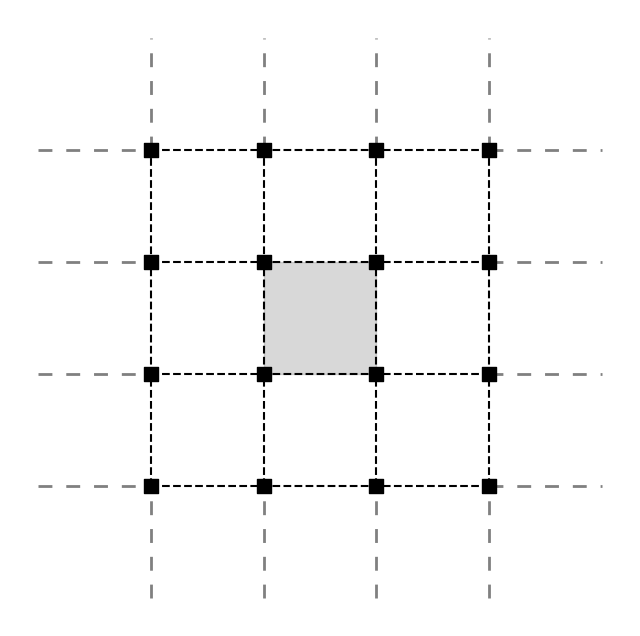

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    plt.plot([i, i], [0, grid_size - 1], c='black', linestyle='--')
    plt.plot([i, i], [-1, 0], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([i, i], [grid_size - 1, grid_size], c='gray', linestyle=(0, (5, 5)), linewidth=2)

    plt.plot([0, grid_size - 1], [i, i], c='black', linestyle='--')
    plt.plot([-1, 0], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([grid_size - 1, grid_size], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)    

plt.fill_between([1, 2], [2, 2], [1, 1], color='gray', alpha=0.3)
plt.scatter(cpoints_x, cpoints_y, c='black', marker='s', s=100, zorder=100)

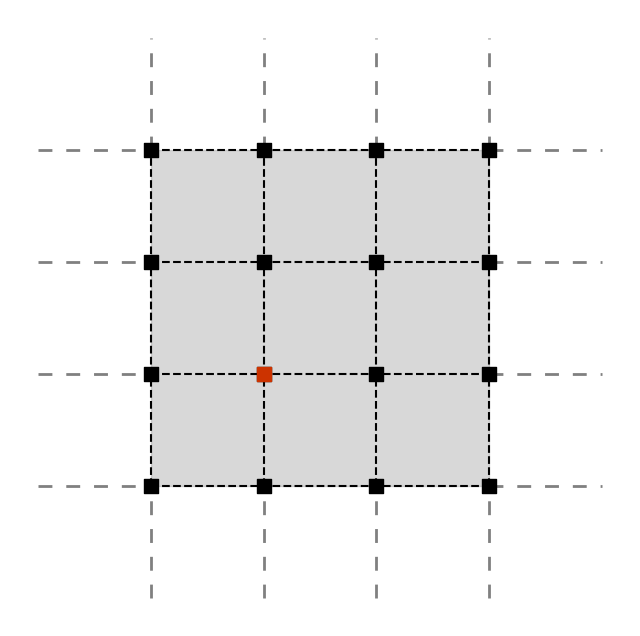

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    plt.plot([i, i], [0, grid_size - 1], c='black', linestyle='--')
    plt.plot([i, i], [-1, 0], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([i, i], [grid_size - 1, grid_size], c='gray', linestyle=(0, (5, 5)), linewidth=2)

    plt.plot([0, grid_size - 1], [i, i], c='black', linestyle='--')
    plt.plot([-1, 0], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([grid_size - 1, grid_size], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)

plt.scatter([1], [1], c='#cc3300', marker='s', s=100, zorder=200)
plt.scatter(cpoints_x, cpoints_y, c='black', marker='s', s=100, zorder=100)
plt.fill_between([0, 3], [0, 0], [3, 3], color='gray', alpha=0.3)

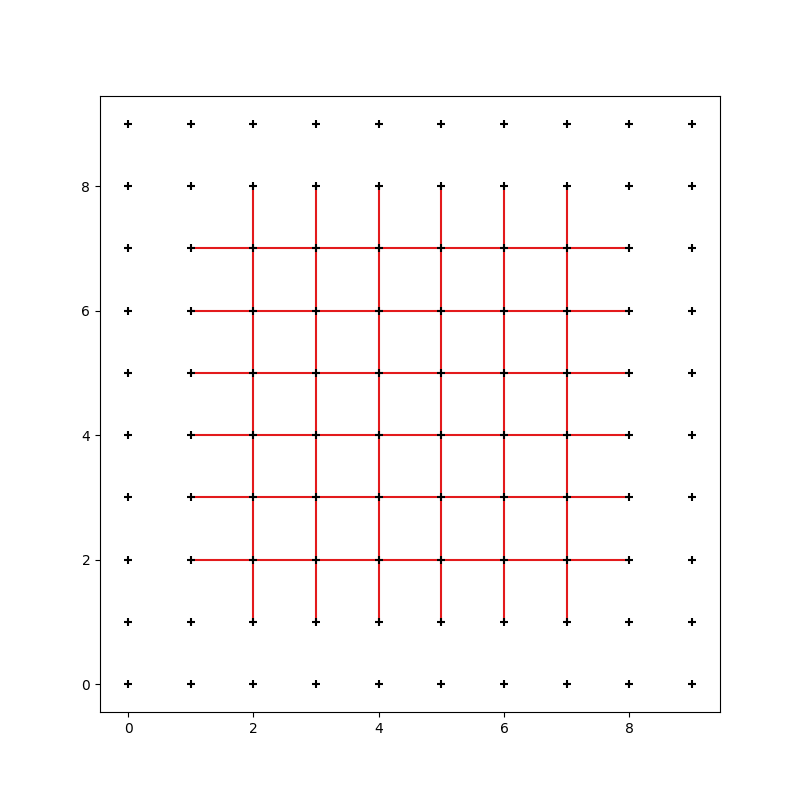

In [3]:
%matplotlib widget

import numpy as np
from matplotlib.lines import Line2D
from matplotlib.artist import Artist

class BSplineInteractor:
    epsilon = 20

    def __init__(self, grid):
        fig, ax = plt.subplots(1,1,figsize=(8,8),sharex=True)
        canvas = fig.canvas

        self.grid = grid
        self.ax = ax
        self.canvas = canvas
        self._ind = None

        canvas.mpl_connect('button_press_event', self.on_button_press)
        canvas.mpl_connect('button_release_event', self.on_button_release)
        canvas.mpl_connect('motion_notify_event', self.on_mouse_move)

        self.redraw()

    def redraw(self):
        self.ax.cla()
        plot_patch(self.grid, self.ax)
        self.ax.figure.canvas.draw_idle()

    def get_ind_under_point(self, event):
        """
        Return the index of the point closest to the event position or *None*
        if no point is within ``self.epsilon`` to the event position.
        """
        tinv = self.ax.transData 
        x, y = [p.x for p in self.grid.flatten()], [p.y for p in self.grid.flatten()]
        xr = np.reshape(x,(np.shape(x)[0],1))
        yr = np.reshape(y,(np.shape(y)[0],1))
        xy_vals = np.append(xr,yr,1)
        xyt = tinv.transform(xy_vals)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.hypot(xt - event.x, yt - event.y)
        indseq, = np.nonzero(d == d.min())
        ind = indseq[0]

        if d[ind] >= self.epsilon:
            ind = None
        
        return ind

    def on_button_press(self, event):
        """Callback for mouse button presses."""
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        self._ind = self.get_ind_under_point(event)

    def on_button_release(self, event):
        """Callback for mouse button releases."""
        if event.button != 1:
            return
        self._ind = None
        self.redraw()

    def on_mouse_move(self, event):
        """Callback for mouse movements."""
        if self._ind is None:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        x, y = event.xdata, event.ydata

        self.grid.flatten()[self._ind].x = x
        self.grid.flatten()[self._ind].y = y

if __name__ == '__main__':
    import matplotlib.pyplot as plt

    c = generate_grid(10, False)
    p = BSplineInteractor(c)
    plt.show()


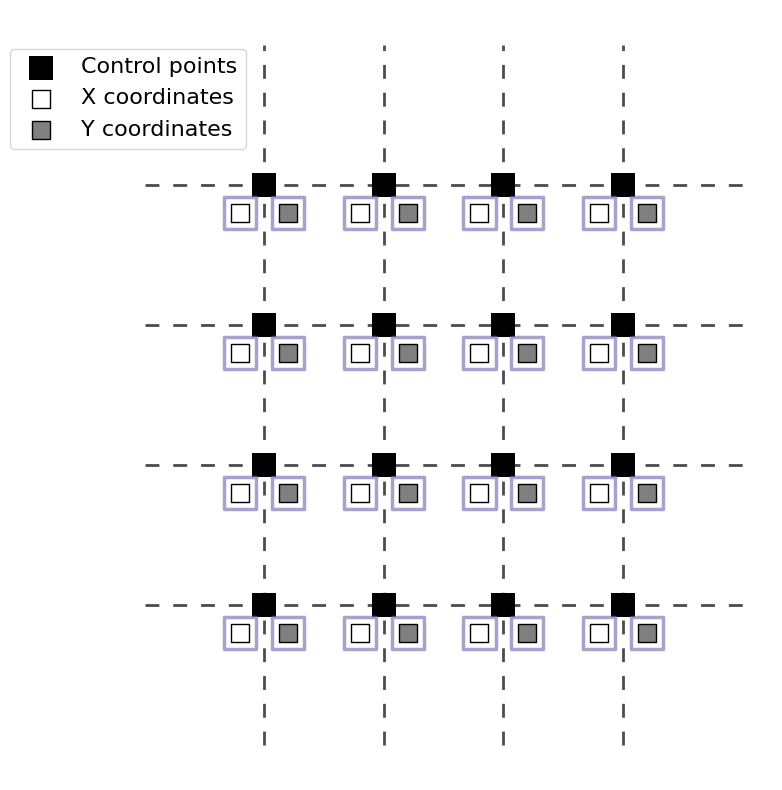

In [47]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

c_x = [p + Point(-0.2, -0.2) for p in c.flatten()]
c_y = [p + Point(0.2, -0.2) for p in c.flatten()]

xcoords_x = [p.x for p in c_x]
xcoords_y = [p.y for p in c_x]
ycoords_x = [p.x for p in c_y]
ycoords_y = [p.y for p in c_y]

for i in range(grid_size):
    ax.plot([i, i], [-1, grid_size], c='black', linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)
    ax.plot([-1, grid_size], [i, i], c='black', linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)

markersize = 300
markersize_small = 180
ax.scatter(cpoints_x, cpoints_y, s=markersize, marker='s', facecolor='black', edgecolor='none', label="Control points")
ax.scatter(xcoords_x, xcoords_y, s=markersize_small, marker='s', facecolor='white', edgecolor='black', label="X coordinates")
ax.scatter(xcoords_x, xcoords_y, s=markersize_small*3, marker='s', facecolor='none', edgecolor='#7570b3', alpha=0.65, linewidth=2.5)
ax.scatter(ycoords_x, ycoords_y, s=markersize_small, marker='s', facecolor='gray', edgecolor='black', label="Y coordinates")
ax.scatter(ycoords_x, ycoords_y, s=markersize_small*3, marker='s', facecolor='none', edgecolor='#7570b3', alpha=0.65, linewidth=2.5)

ax.axis("off")
ax.legend(bbox_to_anchor=(0.2, 0.95), borderaxespad=0, prop={'size': 16})
ax.get_figure().tight_layout()

plt.savefig("univariate_model.pdf")

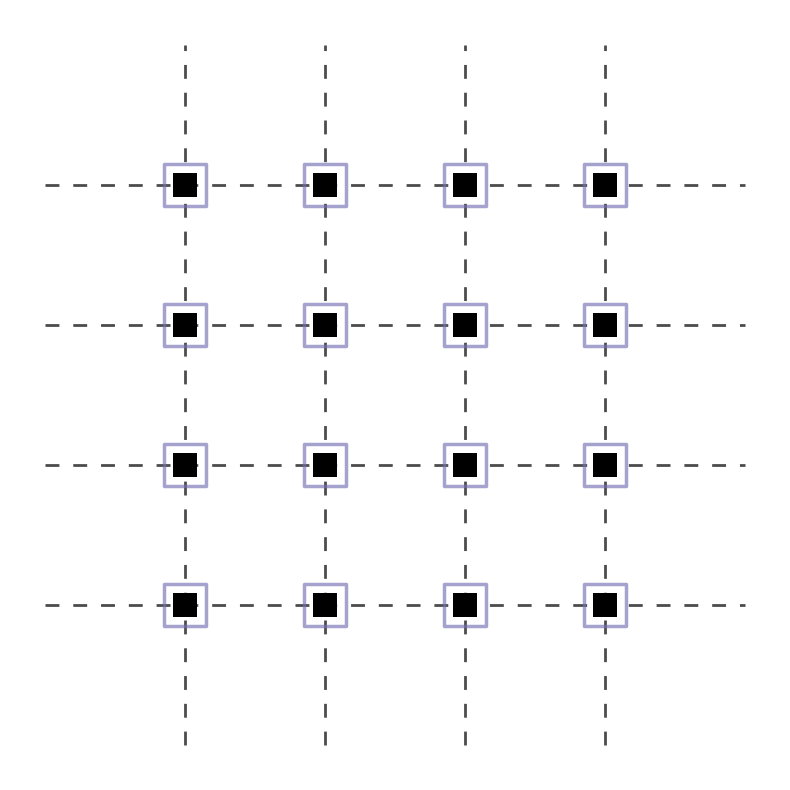

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

zs_indices = [0, 1]
zs_colors = ['black', 'gray']
j=0

for i in range(grid_size):
    ax.plot([i, i], [-1, grid_size], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)
    ax.plot([-1, grid_size], [i, i], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)

markersize = 300
ax.scatter(cpoints_x, cpoints_y, s=markersize, marker='s', facecolor='black', edgecolor='none')
ax.scatter(cpoints_x, cpoints_y, s=markersize*3, marker='s', facecolor='none', edgecolor='#7570b3', alpha=0.65, linewidth=2.5)
ax.axis("off")
ax.get_figure().tight_layout()

plt.savefig("marginal_model.pdf")

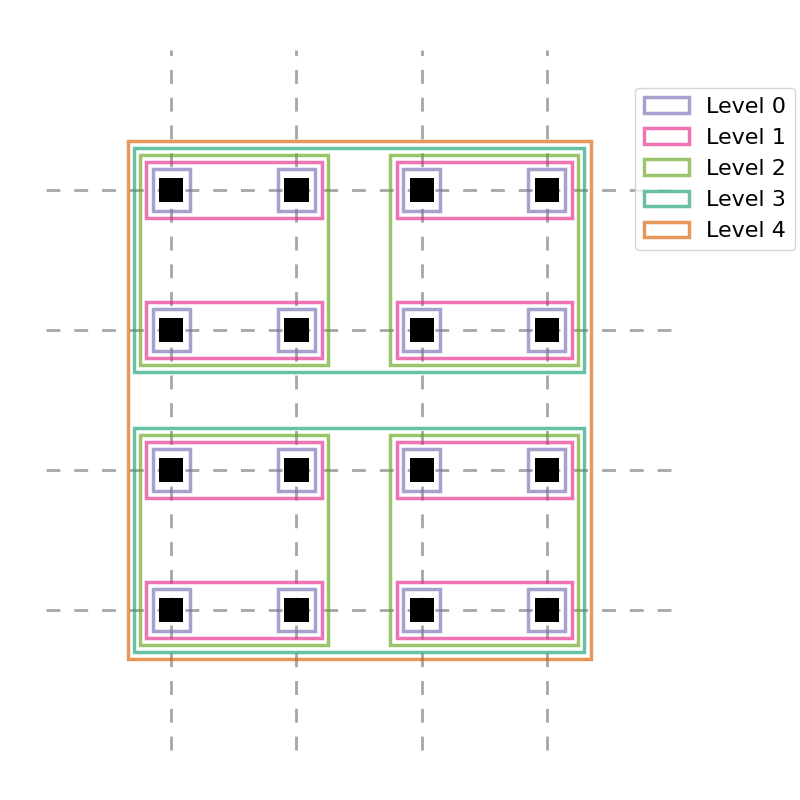

In [216]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    ax.plot([i, i], [-1, grid_size], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)
    ax.plot([-1, grid_size], [i, i], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)

markersize = 300
ax.scatter(cpoints_x, cpoints_y, s=markersize, marker='s', facecolor='black', edgecolor='none')

colors = ["#7570b3", "#e7298a", "#66a61e", "#1b9e77", "#d95f02"]
levels = [
    [Rectangle((p.x-0.15, p.y-0.15), 0.3, 0.3, facecolor='none', edgecolor=colors[0], alpha=0.65, linewidth=2.5, label="Level 0") for p in c.flatten()],
    [Rectangle((p.x-0.2, p.y-0.2), 1.4, 0.4, facecolor='none', edgecolor=colors[1], alpha=0.65, linewidth=2.5, label="Level 1") for p in c.flatten() if p.x == 0 or p.x == 2],
    [Rectangle((p.x-0.25, p.y-0.25), 1.5, 1.5, facecolor='none', edgecolor=colors[2], alpha=0.65, linewidth=2.5, label="Level 2") for p in c.flatten() if (p.x == 0 or p.x == 2) and (p.y == 0 or p.y == 2)],
    [Rectangle((p.x-0.3, p.y-0.3), 3.6, 1.6, facecolor='none', edgecolor=colors[3], alpha=0.65, linewidth=2.5, label="Level 3") for p in c.flatten() if p.x == 0  and (p.y == 0 or p.y == 2)],
    [Rectangle((-0.35, -0.35), 3.7, 3.7, facecolor='none', edgecolor=colors[4], alpha=0.65, linewidth=2.5, label="Level 4")]
]


for level in levels:
    for rect in level:
        ax.add_patch(rect)

ax.axis("off")

handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, prop={'size': 16}, loc='center right', bbox_to_anchor=(1.15, 0.8))

ax.get_figure().tight_layout()

plt.savefig("static_model.pdf")

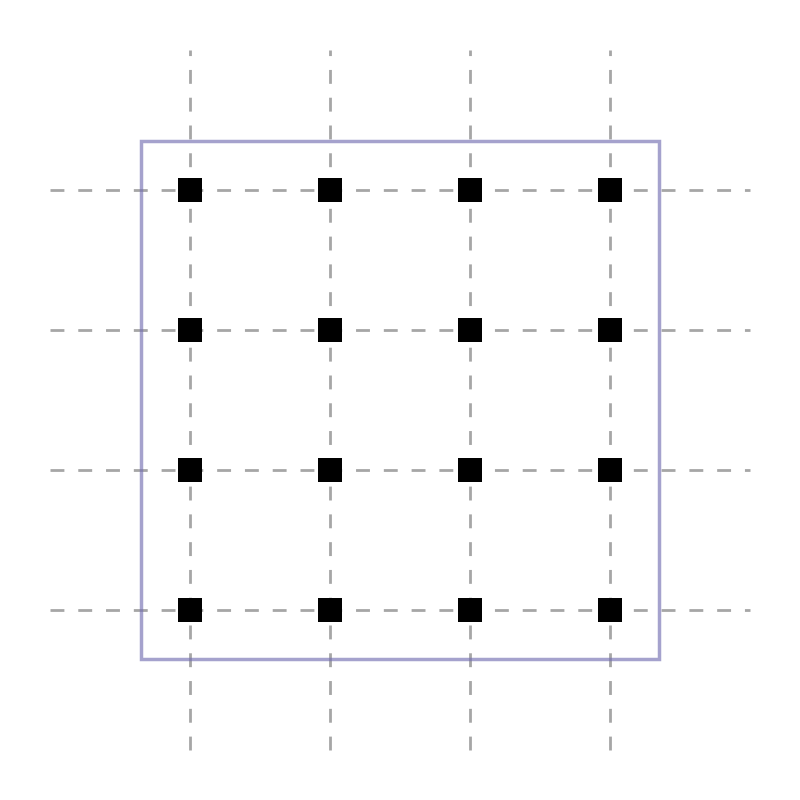

In [217]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    ax.plot([i, i], [-1, grid_size], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)
    ax.plot([-1, grid_size], [i, i], c=zs_colors[j], linestyle=(0, (5, 5)), linewidth=2, alpha=0.7, zorder=1)

markersize = 300
ax.scatter(cpoints_x, cpoints_y, s=markersize, marker='s', facecolor='black', edgecolor='none')

colors = ["#7570b3", "#e7298a", "#66a61e", "#1b9e77", "#d95f02"]
levels = [
    [Rectangle((-0.35, -0.35), 3.7, 3.7, facecolor='none', edgecolor=colors[0], alpha=0.65, linewidth=2.5)]
]


for level in levels:
    for rect in level:
        ax.add_patch(rect)

ax.axis("off")
ax.get_figure().tight_layout()
plt.savefig("full_model.pdf")